In [1]:
from csv import QUOTE_NONNUMERIC

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from memote import ReportConfiguration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = 16, 9

In [6]:
colors = [
  "#A6A9AA",
  "#000000",
  "#3E7CBC",
  "#A3D2E2",
  "#DDEDF6",
  "#EDA85F",
  "#CD2028"
]

## Extract

In [7]:
bucket = []
for filename, collection in [
    ("../data/bigg.csv.gz", "bigg"),
    ("../data/uminho.csv.gz", "uminho"),
    ("../data/mmodel.csv.gz", "ebrahim"),
    ("../data/agora.csv.gz", "agora"),
    ("../data/embl_gems.csv.gz", "embl"),
    ("../data/path2models.csv.gz", "path"),
    ("../data/seed.csv.gz", "seed"),
]:
    tmp = pd.read_csv(filename)
    tmp["collection"] = collection
    bucket.append(tmp)
df = pd.concat(bucket, ignore_index=True)

In [8]:
df.shape

(1379545, 8)

In [9]:
df.head()

,test,title,section,metric,numeric,model,time,collection
0,test_absolute_extreme_coefficient_ratio,Ratio Min/Max Non-Zero Coefficients,matrix,0.0,2.706242e+07,iE2348C_1286,0.046556,bigg
1,test_biomass_consistency,Biomass Consistency,test_biomass,0.0,9.996578e-01,iE2348C_1286,0.000978,bigg
2,test_biomass_consistency,Biomass Consistency,test_biomass,0.0,9.999945e-01,iE2348C_1286,0.000775,bigg
3,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,1.0,0.000000e+00,iE2348C_1286,0.006497,bigg
4,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,0.0,9.824784e-01,iE2348C_1286,0.739684,bigg


## Transform

### Restrict to Scored Test Cases

In [10]:
config = ReportConfiguration.load()

In [11]:
scored = set(config["cards"]["scored"]["sections"])

In [12]:
scored_df = df[df["section"].isin(scored)].copy()

In [13]:
scored_df.shape

(876467, 8)

### Pivot Table

Each model from each collection is one observation (row) and each test case constitutes one variable or category (column) measuring model performance.

In [14]:
scored_df.set_index(["collection", "model", "test"], inplace=True)

Check for duplicates which will prevent unstacking.

In [15]:
scored_df[scored_df.index.duplicated(keep=False)].sort_index()

,,,title,section,metric,numeric,time
collection,model,test,,,,,


In [16]:
observations = scored_df.loc[:, ["metric"]].unstack()
observations.head()

metric  \
test                                             test_biomass_specific_sbo_presence   
collection model                                                                      
agora      Abiotrophia_defectiva_ATCC_49176                                     1.0   
           Achromobacter_xylosoxidans_A8                                        1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                1.0   
           Acidaminococcus_fermentans_DSM_20731                                 1.0   
           Acidaminococcus_intestini_RyC_MR95                                   1.0   

                                                                                    \
test                                             test_demand_specific_sbo_presence   
collection model                                                                     
agora      Abiotrophia_defectiva_ATCC_49176                                    1.0   
           Achromobacter_xylosoxidans_A8                                       1.0   
           Achromobacter_xylosoxidans_NBRC_15126                               1.0   
           Acidaminococcus_fermentans_DSM_20731                                1.0   
           Acidaminococcus_intestini_RyC_MR95                                  1.0   

                                                                                      \
test                                             test_exchange_specific_sbo_presence   
collection model                                                                       
agora      Abiotrophia_defectiva_ATCC_49176                                      1.0   
           Achromobacter_xylosoxidans_A8                                         1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                 1.0   
           Acidaminococcus_fermentans_DSM_20731                                  1.0   
           Acidaminococcus_intestini_RyC_MR95                                    1.0   

                                                                         \
test                                             test_find_disconnected   
collection model                                                          
agora      Abiotrophia_defectiva_ATCC_49176                         0.0   
           Achromobacter_xylosoxidans_A8                            0.0   
           Achromobacter_xylosoxidans_NBRC_15126                    0.0   
           Acidaminococcus_fermentans_DSM_20731                     0.0   
           Acidaminococcus_intestini_RyC_MR95                       0.0   

                                                                                                       \
test                                             test_find_reactions_unbounded_flux_default_condition   
collection model                                                                                        
agora      Abiotrophia_defectiva_ATCC_49176                                                0.185259     
           Achromobacter_xylosoxidans_A8                                                   0.335968     
           Achromobacter_xylosoxidans_NBRC_15126                                           0.324324     
           Acidaminococcus_fermentans_DSM_20731                                            0.253521     
           Acidaminococcus_intestini_RyC_MR95                                              0.184783     

                                                                                             \
test                                             test_gene_product_annotation_overview-asap   
collection model                                                                              
agora      Abiotrophia_defectiva_ATCC_49176                                             1.0   
           Achromobacter_xylosoxidans_A8                                                1.0   
           Achromobacter_xylosoxidans_NBRC_15126                     

### Handle Missing Values

In [17]:
observations.isna().sum(axis=0).sort_values(ascending=False)

        test                                                  
metric  test_gene_product_annotation_overview-ncbigi              59
        test_gene_product_annotation_overview-asap                59
        test_gene_product_annotation_overview-ccds                59
        test_gene_product_annotation_overview-ecogene             59
        test_gene_product_annotation_overview-hprd                59
        test_gene_product_annotation_overview-kegg.genes          59
        test_gene_product_annotation_overview-ncbigene            59
        test_gene_product_annotation_overview-ncbiprotein         59
        test_gene_product_annotation_overview-refseq              59
        test_gene_product_annotation_overview-uniprot             59
        test_metabolite_annotation_overview-inchi                  1
        test_metabolite_annotation_overview-bigg.metabolite        1
        test_metabolite_annotation_overview-seed.compound          1
        test_metabolite_annotation_overv

We set the missing values equivalent to being completely wrong, i.e., score = 0.

In [18]:
observations[observations.isna()] = 0.0

## Dimension Reduction

### PCA

In [19]:
%%time
pca = PCA(n_components=2).fit_transform(observations)

CPU times: user 186 ms, sys: 260 ms, total: 446 ms
Wall time: 72 ms


In [20]:
x = []
y = []
lbl = []
for label in observations.index.get_level_values("collection").unique():
    mask = observations.index.get_level_values("collection") == label
    x.extend(pca[mask, 0])
    y.extend(pca[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/score_pca.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

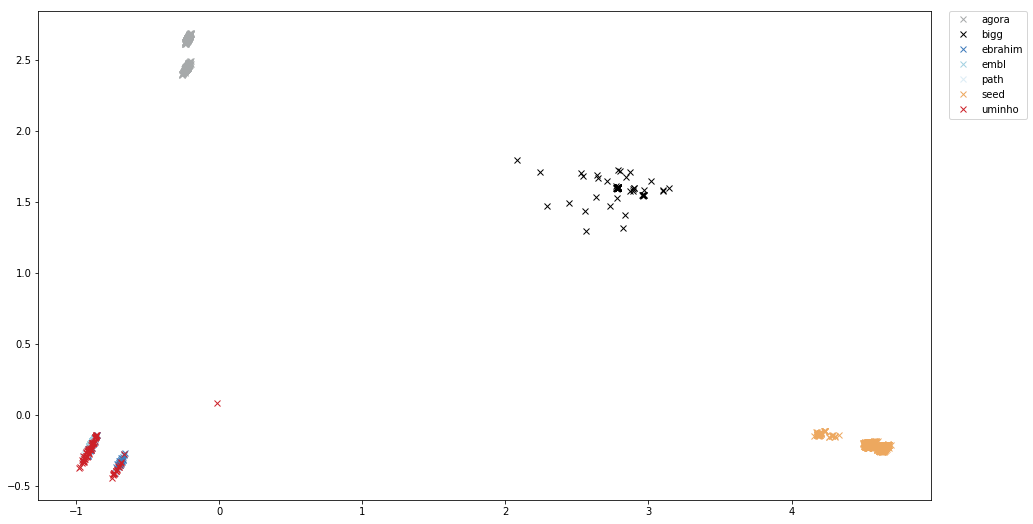

In [21]:
for label, color in zip(observations.index.get_level_values("collection").unique(), colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(pca[mask, 0], pca[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### t-SNE

In [22]:
%%time
tsne = TSNE(n_components=2).fit_transform(observations)

CPU times: user 1min 16s, sys: 11 ms, total: 1min 16s
Wall time: 1min 16s


In [23]:
x = []
y = []
lbl = []
for label in observations.index.get_level_values("collection").unique():
    mask = observations.index.get_level_values("collection") == label
    x.extend(tsne[mask, 0])
    y.extend(tsne[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/score_tsne.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

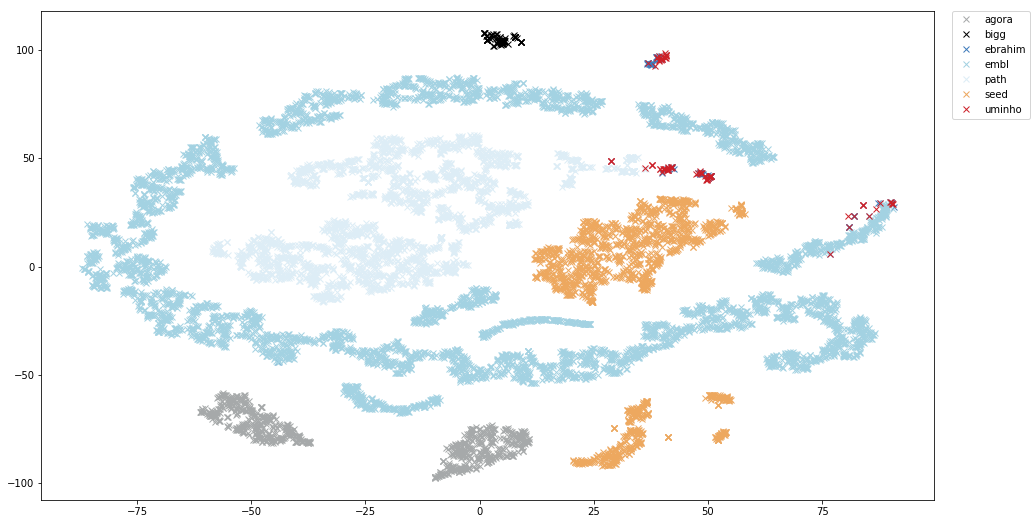

In [24]:
for label, color in zip(observations.index.get_level_values("collection").unique(), colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(tsne[mask, 0], tsne[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### UMAP

In [25]:
%%time
umap = UMAP(n_components=2).fit_transform(observations)

/home/moritz/.virtualenvs/memote-meta/lib/python3.6/site-packages/umap/spectral.py:229 UserWarning: Embedding a total of 8 separate connected components using meta-embedding (experimental)


CPU times: user 21.3 s, sys: 4.23 s, total: 25.6 s
Wall time: 19.3 s


In [26]:
x = []
y = []
lbl = []
for label in observations.index.get_level_values("collection").unique():
    mask = observations.index.get_level_values("collection") == label
    x.extend(umap[mask, 0])
    y.extend(umap[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/score_umap.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

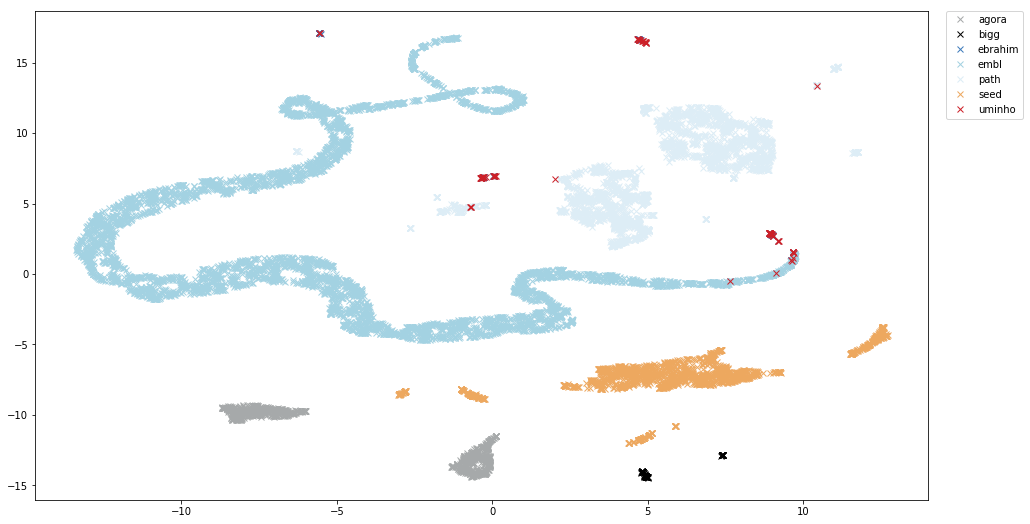

In [27]:
for label, color in zip(observations.index.get_level_values("collection").unique(), colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(umap[mask, 0], umap[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()